In [351]:
# Import the required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas

In [352]:
# Read in Crypto Data
file2 = Path('../datasets/btc_df_min.csv')
btc_df = pd.read_csv(file2)



file3 = Path('../datasets/btc_sentiment_minute.csv')
btc_tw_df = pd.read_csv(file3)
btc_tw_df


,Date,nltk_polarity
0,2022-06-06 04:13:00+00:00,0.164000
1,2022-06-06 04:14:00+00:00,0.045167
2,2022-06-06 04:15:00+00:00,-0.005493
3,2022-06-06 04:16:00+00:00,0.005924
4,2022-06-06 04:17:00+00:00,0.225240
...,...,...
1789,2022-06-07 10:02:00+00:00,0.100042
1790,2022-06-07 10:03:00+00:00,0.074920
1791,2022-06-07 10:04:00+00:00,0.090621
1792,2022-06-07 10:05:00+00:00,-0.000779


In [353]:
# fix btc_df index
new_date = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f") for i in btc_df["date"]]
btc_df["Time"] = new_date
btc_df = btc_df.drop("date", axis=1)

now = datetime.now()

def minute_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=t.minute, hour=t.hour)+timedelta(hours=t.second//30))


btc_df['Time'] = btc_df['Time'].apply(lambda t: minute_rounder(t))

btc_df.reset_index()
btc_df = btc_df.set_index("Time")
btc_df

,close
Time,
2022-06-06 11:00:00,41483.04
2022-06-06 11:01:00,41449.72
2022-06-06 11:02:00,41473.54
2022-06-06 11:03:00,41485.81
2022-06-06 11:04:00,41504.49
...,...
2022-06-07 20:23:00,41136.78
2022-06-07 20:24:00,41145.11
2022-06-07 20:25:00,41155.09


In [354]:
# fix btc_tw_df index
new_date = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S%z") for i in btc_tw_df["Date"]]
btc_tw_df["Time"] = new_date
btc_tw_df = btc_tw_df.drop("Date", axis=1)

btc_tw_df['Time'] = btc_tw_df['Time'].dt.tz_localize(None)
btc_tw_df.reset_index()
btc_tw_df = btc_tw_df.set_index("Time")
btc_tw_df


,nltk_polarity
Time,
2022-06-06 04:13:00,0.164000
2022-06-06 04:14:00,0.045167
2022-06-06 04:15:00,-0.005493
2022-06-06 04:16:00,0.005924
2022-06-06 04:17:00,0.225240
...,...
2022-06-07 10:02:00,0.100042
2022-06-07 10:03:00,0.074920
2022-06-07 10:04:00,0.090621


In [355]:
combined_df = pd.concat([btc_df, btc_tw_df], axis=1)
combined_df = combined_df.dropna()

In [356]:
# Calculate the hourly returns using the closing prices and the pct_change function
combined_df["actual_returns"] = combined_df["close"].pct_change()
combined_df = combined_df.dropna()
combined_df

,close,nltk_polarity,actual_returns
Time,,,
2022-06-06 11:01:00,41449.72,0.256154,-0.000803
2022-06-06 11:02:00,41473.54,0.213744,0.000575
2022-06-06 11:03:00,41485.81,0.382550,0.000296
2022-06-06 11:04:00,41504.49,0.213087,0.000450
2022-06-06 11:05:00,41560.00,0.072058,0.001337
...,...,...,...
2022-06-07 10:02:00,43605.19,0.100042,-0.000374
2022-06-07 10:03:00,43618.78,0.074920,0.000312
2022-06-07 10:04:00,43616.58,0.090621,-0.000050


In [357]:
# Define a window size of 50 & 100
short_window = 50
long_window = 100

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
combined_df["sma_50"] = combined_df["close"].rolling(window=short_window).mean()
combined_df["sma_100"] = combined_df["close"].rolling(window=long_window).mean()
combined_df = combined_df.dropna()
combined_df


,close,nltk_polarity,actual_returns,sma_50,sma_100
Time,,,,,
2022-06-06 12:40:00,42492.45,0.202188,-0.000191,42260.3588,41933.8027
2022-06-06 12:41:00,42492.69,0.062325,0.000006,42269.5366,41944.2324
2022-06-06 12:42:00,42514.23,0.116947,0.000507,42279.1890,41954.6393
2022-06-06 12:43:00,42480.58,0.185000,-0.000791,42289.2902,41964.5870
2022-06-06 12:44:00,42457.38,0.148804,-0.000546,42297.7762,41974.1159
...,...,...,...,...,...
2022-06-07 10:02:00,43605.19,0.100042,-0.000374,43654.3074,43719.2186
2022-06-07 10:03:00,43618.78,0.074920,0.000312,43652.7642,43717.5456
2022-06-07 10:04:00,43616.58,0.090621,-0.000050,43651.2382,43715.6478


## Labelling Data

In [358]:
# Set the Signal column
combined_df["sma_signal"] = 0.0

# Generate the trading signal 1 or 0,
# where 1 is when the EMA50 is greater than (or crosses over) the EMA100
# where 0 is when the EMA50 is under the EMA100
combined_df["sma_signal"][short_window:] = np.where(
    combined_df["sma_50"][short_window:] > combined_df["sma_50"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
combined_df["Entry/Exit"] = combined_df["sma_signal"].diff()

# Review the DataFrame
combined_df

c:\Users\samro\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\samro\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._set_values(indexer, value)
c:\Users\samro\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,close,nltk_polarity,actual_returns,sma_50,sma_100,sma_signal,Entry/Exit
Time,,,,,,,
2022-06-06 12:40:00,42492.45,0.202188,-0.000191,42260.3588,41933.8027,0.0,NaN
2022-06-06 12:41:00,42492.69,0.062325,0.000006,42269.5366,41944.2324,0.0,0.0
2022-06-06 12:42:00,42514.23,0.116947,0.000507,42279.1890,41954.6393,0.0,0.0
2022-06-06 12:43:00,42480.58,0.185000,-0.000791,42289.2902,41964.5870,0.0,0.0
2022-06-06 12:44:00,42457.38,0.148804,-0.000546,42297.7762,41974.1159,0.0,0.0
...,...,...,...,...,...,...,...
2022-06-07 10:02:00,43605.19,0.100042,-0.000374,43654.3074,43719.2186,0.0,0.0
2022-06-07 10:03:00,43618.78,0.074920,0.000312,43652.7642,43717.5456,0.0,0.0
2022-06-07 10:04:00,43616.58,0.090621,-0.000050,43651.2382,43715.6478,0.0,0.0


In [359]:
# getting summary statistics on polarity scores
combined_df["nltk_polarity"].describe()

count    1287.000000
mean        0.149558
std         0.118049
min        -0.358010
25%         0.075723
50%         0.151900
75%         0.232054
max         0.498341
Name: nltk_polarity, dtype: float64

In [360]:
# Create a new column in the btc_df called signal setting its value to zero.
combined_df["Signal"] = 1

# Create the signal to buy
combined_df.loc[(combined_df["actual_returns"] > 0) & (combined_df['nltk_polarity'] > 0.2), "Signal"] = 1

# Create the signal to sell
combined_df.loc[(combined_df["actual_returns"] < 0) & (combined_df['nltk_polarity'] <= 0.2), "Signal"] = -1


y = combined_df["Signal"].copy()

# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = combined_df[["sma_50", "sma_100", 'nltk_polarity']].copy()
combined_df

c:\Users\samro\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\samro\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,close,nltk_polarity,actual_returns,sma_50,sma_100,sma_signal,Entry/Exit,Signal
Time,,,,,,,,
2022-06-06 12:40:00,42492.45,0.202188,-0.000191,42260.3588,41933.8027,0.0,NaN,1
2022-06-06 12:41:00,42492.69,0.062325,0.000006,42269.5366,41944.2324,0.0,0.0,1
2022-06-06 12:42:00,42514.23,0.116947,0.000507,42279.1890,41954.6393,0.0,0.0,1
2022-06-06 12:43:00,42480.58,0.185000,-0.000791,42289.2902,41964.5870,0.0,0.0,-1
2022-06-06 12:44:00,42457.38,0.148804,-0.000546,42297.7762,41974.1159,0.0,0.0,-1
...,...,...,...,...,...,...,...,...
2022-06-07 10:02:00,43605.19,0.100042,-0.000374,43654.3074,43719.2186,0.0,0.0,-1
2022-06-07 10:03:00,43618.78,0.074920,0.000312,43652.7642,43717.5456,0.0,0.0,1
2022-06-07 10:04:00,43616.58,0.090621,-0.000050,43651.2382,43715.6478,0.0,0.0,-1


## ML Implementation

In [361]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)

In [362]:
# Imports
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [363]:
# Imports SVM Machine Learning Model
from sklearn import svm
from sklearn.metrics import classification_report

In [364]:
y_train.unique()

array([-1,  1], dtype=int64)

In [365]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1], dtype=int64)

In [366]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.56      0.44      0.49       283
           1       0.75      0.83      0.79       579

    accuracy                           0.70       862
   macro avg       0.65      0.63      0.64       862
weighted avg       0.69      0.70      0.69       862



In [367]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [368]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.45      0.44      0.45       127
           1       0.76      0.77      0.77       298

    accuracy                           0.67       425
   macro avg       0.61      0.61      0.61       425
weighted avg       0.67      0.67      0.67       425



In [369]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [370]:
# Run ML Model 1 - Logisitic Regression
model_1 = LogisticRegression()
model_1.fit(X_train_scaled, y_train)
ypred_lr = model_1.predict(X_test_scaled)

In [371]:
# Run ML Model 2 - Gaussian NB
model_2 = GaussianNB()
model_2.fit(X_train_scaled, y_train)
ypred_GNB = model_2.predict(X_test_scaled)

In [372]:
# Run ML Model 3 - Random Forest Classifier
model_3 = RandomForestClassifier()
model_3.fit(X_train_scaled, y_train)
ypred_RFC = model_3.predict(X_test_scaled)

In [373]:
eclf = VotingClassifier(
 estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
 voting='hard'
)
eclf.fit(X_train_scaled,y_train)
ypred_vc = eclf.predict(X_test_scaled)


for clf, label in zip([svm_model, model_1, model_2, model_3, eclf], ['Support Vector', 'Logistic Regression', 'Naive Bayes', 'Random Forest', 'Ensemble']):
 scores = cross_val_score(clf, X, y, scoring='accuracy', cv=4)
 print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.68 (+/- 0.00) [Support Vector]
Accuracy: 0.68 (+/- 0.00) [Logistic Regression]
Accuracy: 0.66 (+/- 0.04) [Naive Bayes]
Accuracy: 0.65 (+/- 0.03) [Random Forest]
Accuracy: 0.68 (+/- 0.01) [Ensemble]


In [374]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["Predict_SVM"] = testing_signal_predictions
predictions_df["Predict_LR"] = ypred_lr
predictions_df["Predict_NB"] = ypred_GNB
predictions_df["Predict_RF"] = ypred_RFC
predictions_df["Predict_EM"] = ypred_vc
predictions_df['score'] = predictions_df.sum(axis=1)
predictions_df["actual_returns"] = total_data["actual_returns"]
predictions_df["SVM_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_SVM"]
predictions_df["LR_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_LR"]
predictions_df["GNB_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_NB"]
predictions_df["RFC_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_RF"]
predictions_df["EM_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_EM"]


predictions_df.tail()

,Predict_SVM,Predict_LR,Predict_NB,Predict_RF,Predict_EM,score,actual_returns,SVM_Predictions,LR_Predictions,GNB_Predictions,RFC_Predictions,EM_Predictions
Time,,,,,,,,,,,,
2022-06-07 08:21:00,1,1,1,1,1,5,-0.001128,-0.001128,-0.001128,-0.001128,-0.001128,-0.001128
2022-06-06 22:28:00,1,1,1,1,1,5,-0.000596,-0.000596,-0.000596,-0.000596,-0.000596,-0.000596
2022-06-07 09:19:00,1,1,1,1,1,5,0.000416,0.000416,0.000416,0.000416,0.000416,0.000416
2022-06-07 04:13:00,1,1,1,-1,1,3,0.000435,0.000435,0.000435,0.000435,-0.000435,0.000435
2022-06-07 06:22:00,-1,1,-1,-1,-1,-3,0.000988,-0.000988,0.000988,-0.000988,-0.000988,-0.000988


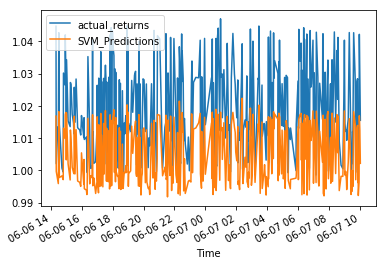

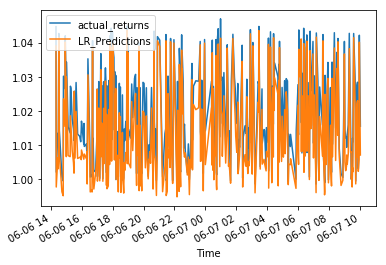

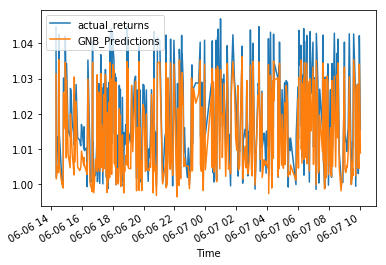

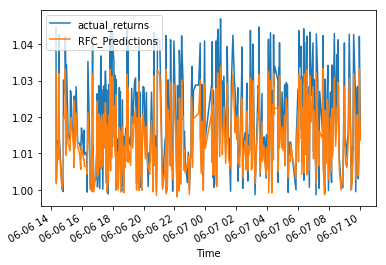

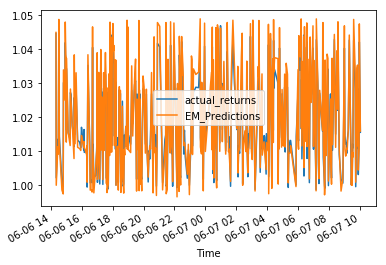

In [375]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "SVM_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "LR_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "GNB_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "RFC_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "EM_Predictions"]]).cumprod().plot()

In [377]:
predict_df = pd.concat([combined_df[['close', 'nltk_polarity']], predictions_df[['Predict_SVM','Predict_LR','Predict_NB','Predict_RF','Predict_EM', 'score']]], axis=1)
predict_df = predict_df.dropna()
predict_df

,close,nltk_polarity,Predict_SVM,Predict_LR,Predict_NB,Predict_RF,Predict_EM,score
Time,,,,,,,,
2022-06-06 12:43:00,42480.58,0.185000,1.0,1.0,1.0,1.0,1.0,5.0
2022-06-06 12:45:00,42440.29,0.077386,1.0,1.0,1.0,1.0,1.0,5.0
2022-06-06 12:50:00,42767.99,0.090292,1.0,1.0,1.0,1.0,1.0,5.0
2022-06-06 13:03:00,42806.45,0.417067,1.0,1.0,1.0,1.0,1.0,5.0
2022-06-06 13:09:00,42897.94,0.246809,1.0,1.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...
2022-06-07 09:54:00,43669.79,0.051738,1.0,1.0,-1.0,-1.0,-1.0,-1.0
2022-06-07 09:57:00,43620.39,0.166796,1.0,1.0,1.0,-1.0,1.0,3.0
2022-06-07 09:58:00,43624.55,-0.092896,1.0,-1.0,-1.0,-1.0,-1.0,-3.0


In [378]:
# Initialize trade_type column for buys and sells
predict_df['trade_type'] = np.nan

# Initialize variable to hold the previous_price
previous_price = 0


# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in predict_df.iterrows():
    score = predict_df.index
    
    # buy if the previous price is 0 and Twitter Sentiment has Positive for 7 consecutive days.
    if previous_price == 0:
        predict_df.loc[index, "trade_type"] = "buy"
        

    # buy if the current day price is less than the previous day price and Twitter Sentiment is greater than 0.02
    elif row["close"] < previous_price and row['nltk_polarity'] > 0.16 or row["close"] < previous_price and row['score'] >= 3 :
        predict_df.loc[index, "trade_type"] = "buy"
        

    # sell if the current day price is greater than the previous day price and Twitter Sentiment is less than 0.015
    elif row["close"] > previous_price and row['nltk_polarity'] <= 0.3 or row["close"] > previous_price and row["score"] <= -3:
        predict_df.loc[index, "trade_type"] = "sell"
        

    elif row["close"] > previous_price and row['nltk_polarity'] > 0.4:
        predict_df.loc[index, "trade_type"] = "neut"
        
    # else hold if the current day price is equal to the previous day price and Twitter Sentiment is Neutrual or Greater in 4 days
    else:
        predict_df.loc[index, "trade_type"] = "neut"
    
    # reset the previous_price variable to the close price of the current row
    previous_price = row["close"]

    # if the index is the last index of the Dataframe, set the trade_type to sell
    if index == predict_df.index[-1]:
        predict_df.loc[index, "trade_type"] = "sell"


predict_df

,close,nltk_polarity,Predict_SVM,Predict_LR,Predict_NB,Predict_RF,Predict_EM,score,trade_type
Time,,,,,,,,,
2022-06-06 12:43:00,42480.58,0.185000,1.0,1.0,1.0,1.0,1.0,5.0,buy
2022-06-06 12:45:00,42440.29,0.077386,1.0,1.0,1.0,1.0,1.0,5.0,buy
2022-06-06 12:50:00,42767.99,0.090292,1.0,1.0,1.0,1.0,1.0,5.0,sell
2022-06-06 13:03:00,42806.45,0.417067,1.0,1.0,1.0,1.0,1.0,5.0,neut
2022-06-06 13:09:00,42897.94,0.246809,1.0,1.0,1.0,1.0,1.0,5.0,sell
...,...,...,...,...,...,...,...,...,...
2022-06-07 09:54:00,43669.79,0.051738,1.0,1.0,-1.0,-1.0,-1.0,-1.0,neut
2022-06-07 09:57:00,43620.39,0.166796,1.0,1.0,1.0,-1.0,1.0,3.0,buy
2022-06-07 09:58:00,43624.55,-0.092896,1.0,-1.0,-1.0,-1.0,-1.0,-3.0,sell


In [379]:
plot_df = predict_df.reset_index()

# Create a Sell Plot
sell = plot_df[plot_df["trade_type"] == "sell"]["close"].hvplot.scatter(
    color="red",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Buy Plot
buy = plot_df[plot_df["trade_type"] == "buy"]["close"].hvplot.scatter(
    color="green",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Hold Plot
neu = plot_df[plot_df["trade_type"] == "neut"]["close"].hvplot.scatter(
    color="orange",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400) 

security_close = plot_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)    

# Create the overlay plot
buy_sell_plot = buy * sell * neu * security_close

# Show the plot
buy_sell_plot.opts(
    title="Bitcoin - Buy, Sell and Hold Chart"
)   

:Overlay
   .Scatter.Close.I   :Scatter   [index]   (close)
   .Scatter.Close.II  :Scatter   [index]   (close)
   .Scatter.Close.III :Scatter   [index]   (close)
   .Curve.I           :Curve   [index]   (close)